# Visualization of Scan Benchmark Results

Should the plots be saved as PDF?

In [1]:
save_plots = True

### Define some CSV related constants

In [2]:
TYPE_STRING = 1
TYPE_INT = 0
OPERATION_EQUALS = 0
OPERATION_EQUALS_BITSET = 1
OPERATION_EQUALS_DICT = 2
OPERATION_EQUALS_DICT_BITSET = 3
OPERATION_EQUALS_INDEX = 4
OPERATION_EQUALS_BTREE = 5

### Define functions for scatter plots

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def get_df(filename):
    df = pd.read_csv(filename)
    return df

def get_dataframes_per_operation(dataframe):
    df_raw = dataframe[dataframe.operation == OPERATION_EQUALS]
    df_dict = dataframe[dataframe.operation == OPERATION_EQUALS_DICT]
    df_index = dataframe[dataframe.operation == OPERATION_EQUALS_INDEX]
    df_raw_bitset = dataframe[dataframe.operation == OPERATION_EQUALS_BITSET]
    df_dict_bitset = dataframe[dataframe.operation == OPERATION_EQUALS_DICT_BITSET]
    df_btree = dataframe[dataframe.operation == OPERATION_EQUALS_BTREE]
    
    return df_raw, df_dict, df_index, df_raw_bitset, df_dict_bitset, df_btree


def get_mean_durations_per_selectivity(dataframe):
    mean_durations = []
    selectivities = []
    for value in dataframe['selectivity'].unique():
        values = dataframe[dataframe.selectivity == value]
        means = values.mean()
        mean_durations.append(means['duration_microseconds'])
        selectivities.append(means['selectivity'])
    return mean_durations


def get_mean_durations_by_operation_and_selectivity(df1, df2, df3, df4, df5, df6):
    mean_durations_1 = get_mean_durations_per_selectivity(df1)
    mean_durations_2 = get_mean_durations_per_selectivity(df2)
    mean_durations_3 = get_mean_durations_per_selectivity(df3)
    mean_durations_4 = get_mean_durations_per_selectivity(df4)
    mean_durations_5 = get_mean_durations_per_selectivity(df5)
    mean_durations_6 = get_mean_durations_per_selectivity(df6)
    
    return mean_durations_1, mean_durations_2, mean_durations_3, mean_durations_4, mean_durations_5, mean_durations_6


def get_comparing_scatter_plot(x, ys, labels, axes, title):
    # show duration in milliseconds
    y = [[ i * 0.001 for i in y ] for y in ys ]
        
    markers = ['s', 'o', 'x']
    colors = ['orange', 'orange', 'orange', 'green', 'green', 'blue']
        
    
    fig = plt.figure(figsize=(7, 4))
    ax1 = fig.add_subplot(111)
    for i in range(len(ys)):
        ax1.scatter(x, ys[i], marker=markers[i % 3], color=colors[i], label=labels[i])
    plt.xlabel(axes['x_label'])
    plt.ylabel(axes['y_label'])
    plt.suptitle(title)
    plt.grid(b=True)
    plt.xlim(left=-0.01, right=1.01)
    fig.legend(loc=7)
    fig.subplots_adjust(right=0.75)   

    return fig

### Make plots for CSV files

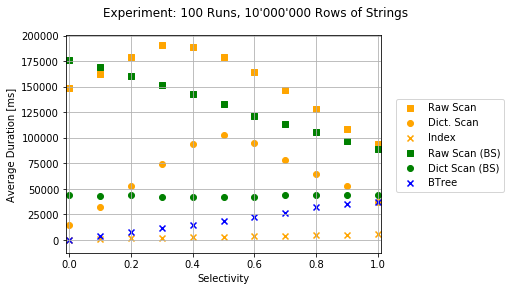

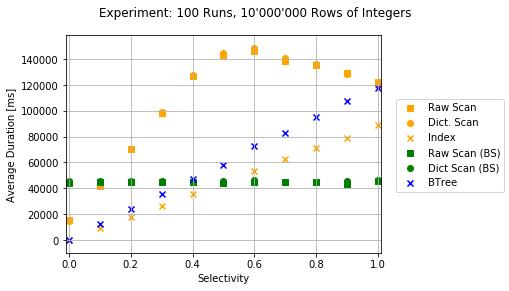

In [4]:
plots = []

axes = {
    'x': 'Selectivity',
    'y': 'AvgDuration',
    'x_label': 'Selectivity', 
    'y_label': 'Average Duration [ms]', 
}


#df = get_df('./out_.csv').sort_values('selectivity', ascending=True)
#df_int = df[df.column_type == TYPE_INT]
#df_string = df[df.column_type == TYPE_STRING]
df_int = get_df('./int.csv').sort_values('selectivity', ascending=True)
df_string = get_df('./string.csv').sort_values('selectivity', ascending=True)
string_raw, string_dict, string_index, string_raw_bitset, string_dict_bitset, string_btree = get_dataframes_per_operation(df_string)
int_raw, int_dict, int_index, int_raw_bitset, int_dict_bitset, int_btree = get_dataframes_per_operation(df_int)

string_raw_mean_durations, string_raw_bs_mean_durations, string_dict_mean_durations, string_dict_bs_mean_durations, string_index_mean_durations, string_btree_mean_durations  = get_mean_durations_by_operation_and_selectivity(string_raw, string_raw_bitset, string_dict, string_dict_bitset, string_index, string_btree)
int_raw_mean_durations, int_raw_bs_mean_durations, int_dict_mean_durations, int_dict_bs_mean_durations, int_index_mean_durations, int_btree_mean_durations = get_mean_durations_by_operation_and_selectivity(int_raw, int_raw_bitset, int_dict, int_dict_bitset, int_index, int_btree)

string_durs = [string_raw_mean_durations, string_dict_mean_durations, string_index_mean_durations, string_raw_bs_mean_durations, string_dict_bs_mean_durations, string_btree_mean_durations ]
int_durs = [int_raw_mean_durations, int_dict_mean_durations, int_index_mean_durations, int_raw_bs_mean_durations, int_dict_bs_mean_durations, int_btree_mean_durations ]

methods = ['Raw Scan', 'Dict. Scan', 'Index', 'Raw Scan (BS)', 'Dict Scan (BS)', 'BTree']
string_selectivities = df_string['selectivity'].unique()
int_selectivities = df_int['selectivity'].unique()

runs = df_string[df_string.selectivity == df_string['selectivity'].unique()[0]].shape[0]
rows = round(df_string.row_count.mean())

plots.append(get_comparing_scatter_plot(string_selectivities, string_durs, methods, axes, 'Experiment: 100 Runs, 10\'000\'000 Rows of Strings'))
plots.append(get_comparing_scatter_plot(string_selectivities, int_durs, methods, axes, 'Experiment: 100 Runs, 10\'000\'000 Rows of Integers'))

### Save plots if requested

In [5]:
if save_plots: 
    with PdfPages("plots week 6.pdf") as pdf:
        for plot in plots:
            pdf.savefig(plot)